<a href="https://www.kaggle.com/code/anthonytherrien/histopathologic-cancer-detection-complete?scriptVersionId=265473453" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Histopathologic Cancer Detection — TIF-Focused Notebook

**Data format:** All images are `.tif`  
**Task:** Binary classification — detect metastatic cancer in small pathology image patches  
**Metric:** ROC AUC  
**Author:** _Your Name_  
**Repo URL:** _add your public GitHub repo link here_

---


## 1) Brief description of the problem and data

- All images are provided as `.tif` files  
- Predict whether the **center 32×32 px** region of a **96×96 px** patch contains tumor tissue  
- `train_labels.csv` has columns: `id,label` where `id` maps to `train/{id}.tif`  
- Evaluation is **ROC AUC**

In [1]:
# Imports
import os
import gc
import math
import time
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd

import tifffile as tiff

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

# Reproducibility
def set_seed(seed):
    # Set python random seed
    random.seed(seed)
    # Set numpy random seed
    np.random.seed(seed)
    # Set torch random seed
    torch.manual_seed(seed)
    # Set CUDA deterministic flags if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Configuration
CFG = {
    "seed": 42,
    "num_workers": 4,
    "train_batch_size": 128,
    "valid_batch_size": 256,
    "img_size": 128,
    "model_name": "efficientnet_b0",
    "in_chans": 3,
    "epochs": 3,
    "lr": 2e-3,
    "weight_decay": 1e-5,
    "folds": 3,
    "tta": 4,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# Paths
DATA_DIR = Path("/kaggle/input/histopathologic-cancer-detection")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
LABELS_CSV = DATA_DIR / "train_labels.csv"
OUTPUT_DIR = Path("./outputs")

# Ensure output dir exists
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Seed everything
set_seed(CFG["seed"])

# Print config
print(CFG)

{'seed': 42, 'num_workers': 4, 'train_batch_size': 128, 'valid_batch_size': 256, 'img_size': 128, 'model_name': 'efficientnet_b0', 'in_chans': 3, 'epochs': 3, 'lr': 0.002, 'weight_decay': 1e-05, 'folds': 3, 'tta': 4, 'device': 'cuda'}



## 2) TIF utilities

The following helpers strictly load `.tif` files, handle 8/16-bit, ensure RGB output, and return `float32` arrays in `[0,1]`.

In [2]:
# Normalize uint8/uint16 arrays to float32 [0,1]
def _normalize_to_float01(arr):
    # Handle uint16
    if arr.dtype == np.uint16:
        # Divide by max 16-bit
        return (arr.astype(np.float32) / 65535.0)
    # Handle uint8
    if arr.dtype == np.uint8:
        # Divide by max 8-bit
        return (arr.astype(np.float32) / 255.0)
    # Already float
    if np.issubdtype(arr.dtype, np.floating):
        # Clip to range
        arr = np.clip(arr, 0.0, 1.0).astype(np.float32)
        # Return array
        return arr
    # Fallback cast
    return arr.astype(np.float32)

# Load a TIF image and ensure RGB float32 [0,1]
def load_tif_as_rgb_float01(path):
    # Read with tifffile
    arr = tiff.imread(str(path))
    # Squeeze singleton dims
    arr = np.squeeze(arr)
    # If grayscale, repeat channels
    if arr.ndim == 2:
        # Stack to 3 channels
        arr = np.stack([arr, arr, arr], axis=-1)
    # If channel-first, move to HWC
    if arr.ndim == 3 and arr.shape[0] in [1,3] and arr.shape[2] not in [1,3]:
        # Transpose to HWC
        arr = np.transpose(arr, (1, 2, 0))
    # If more than 3 channels, take first 3
    if arr.ndim == 3 and arr.shape[2] > 3:
        # Slice first 3 channels
        arr = arr[:, :, :3]
    # If single channel in last dim, repeat
    if arr.ndim == 3 and arr.shape[2] == 1:
        # Repeat to 3 channels
        arr = np.repeat(arr, 3, axis=2)
    # Normalize to float [0,1]
    arr = _normalize_to_float01(arr)
    # Ensure shape is HWC with 3 channels
    assert arr.ndim == 3 and arr.shape[2] == 3, f"Expected HWC with 3 channels, got {arr.shape}"
    # Return array
    return arr

# Verify required TIF exists
def tif_exists(dir_path, image_id):
    # Build path
    p = Path(dir_path) / f"{image_id}.tif"
    # Return existence
    return p.exists()


## 3) EDA — Inspect, visualize, and clean

In [3]:
# Load labels CSV
df = pd.read_csv(LABELS_CSV)

# Show head
print(df.head())

# Label distribution
print(df.label.value_counts(normalize=True))

# Validate that all referenced TIF files exist
missing = [i for i in df.id.values if not tif_exists(TRAIN_DIR, i)]
print(f"Missing train TIF files: {len(missing)}")

# Verify shapes and dtypes on a subset
def inspect_tif(path):
    # Read tif
    arr = tiff.imread(str(path))
    # Return info
    return arr.shape, arr.dtype

# Sample subset
subset_ids = df.id.sample(20, random_state=CFG["seed"]).tolist()

# Inspect shapes
inspect_rows = []
for i in subset_ids:
    # Build path
    p = TRAIN_DIR / f"{i}.tif"
    # Inspect array
    shp, dt = inspect_tif(p)
    # Append row
    inspect_rows.append({"id": i, "shape": shp, "dtype": str(dt)})

# Create dataframe
shape_df = pd.DataFrame(inspect_rows)

# Print sample
print(shape_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64
Missing train TIF files: 0
                                         id        shape  dtype
0  d293308913e4a40cebb809d986aa9add65a76bfa  (96, 96, 3)  uint8
1  fcd55f03496afb4b11598d9c2231e86da318e723  (96, 96, 3)  uint8
2  5c983c8f14afeffdb098b9f3cbb68488a802b957  (96, 96, 3)  uint8
3  71bf03e8530348e57ec07d8ce2052f215390c997  (96, 96, 3)  uint8
4  1533406000e26663c5fadac3bcc3e38285a45bb3  (96, 96, 3)  uint8


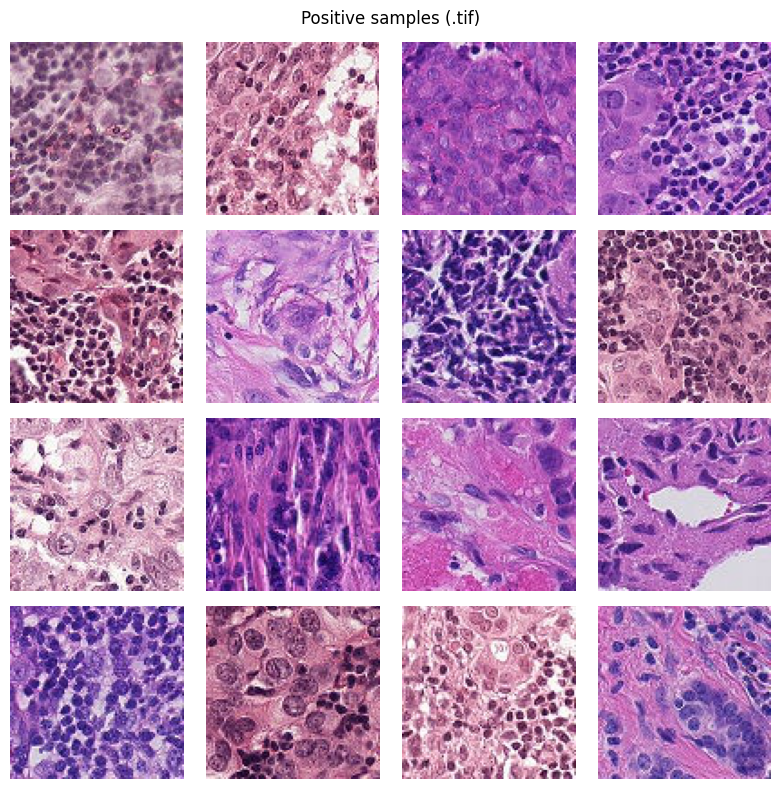

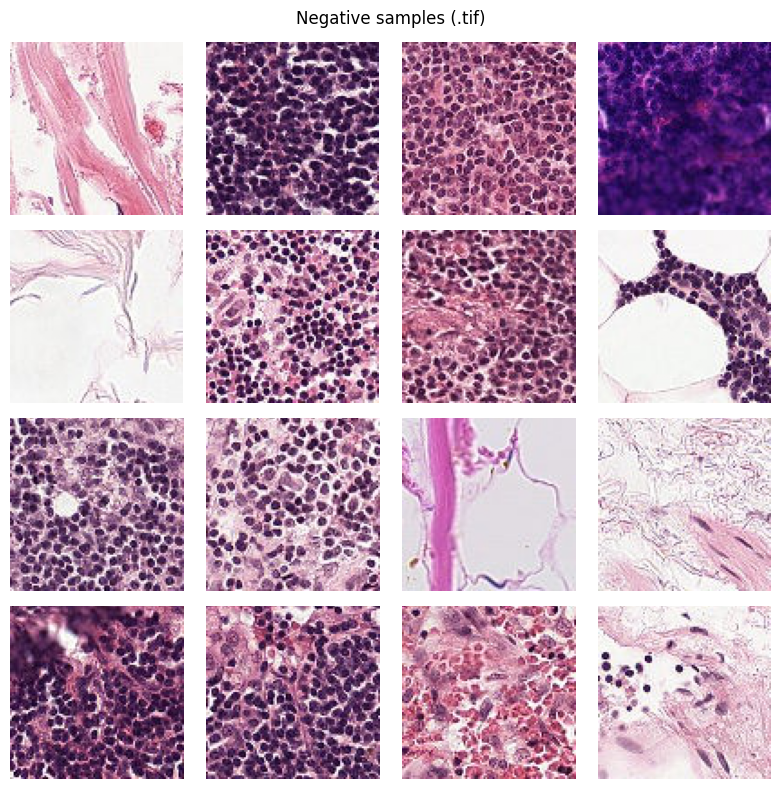

In [4]:
# Plot sample grids from TIF
def plot_tif_samples(ids, title):
    # Create figure
    plt.figure(figsize=(8, 8))
    # Iterate over ids
    for idx, img_id in enumerate(ids[:16]):
        # Build path
        p = TRAIN_DIR / f"{img_id}.tif"
        # Load normalized RGB
        im = load_tif_as_rgb_float01(p)
        # Create subplot
        ax = plt.subplot(4, 4, idx + 1)
        # Show image
        ax.imshow(im)
        # Hide axes
        ax.axis("off")
    # Set title
    plt.suptitle(title)
    # Tight layout
    plt.tight_layout()
    # Show plot
    plt.show()

# Select ids by class
pos_ids = df[df.label == 1].id.sample(16, random_state=CFG["seed"]).tolist()
neg_ids = df[df.label == 0].id.sample(16, random_state=CFG["seed"]).tolist()

# Plot samples
plot_tif_samples(pos_ids, "Positive samples (.tif)")
plot_tif_samples(neg_ids, "Negative samples (.tif)")


## 4) Dataset, transforms, and dataloaders

Albumentations pipelines operate on HWC numpy arrays loaded from `.tif`.  
All inputs are converted to normalized RGB float32 `[0,1]` before augmentation.

In [5]:
# Build augmentations
def build_transforms(img_size, is_train):
    # Compose training transforms
    if is_train:
        # Return training transforms
        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.ColorJitter(p=0.2),
            A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.3),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        # Return validation transforms
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(),
            ToTensorV2(),
        ])

# Dataset class specialized for TIF
class PCamTIFDataset(Dataset):
    # Initialize dataset
    def __init__(self, df, img_dir, transforms=None):
        # Save dataframe
        self.df = df.reset_index(drop=True)
        # Save image directory
        self.img_dir = Path(img_dir)
        # Save transforms
        self.transforms = transforms

    # Dataset length
    def __len__(self):
        # Return length
        return len(self.df)

    # Get item by index
    def __getitem__(self, idx):
        # Fetch row
        row = self.df.iloc[idx]
        # Build path
        img_path = self.img_dir / f"{row['id']}.tif"
        # Load as normalized RGB float
        arr = load_tif_as_rgb_float01(img_path)
        # Apply albumentations
        tensor = self.transforms(image=arr)["image"]
        # Return image and label if present
        if "label" in row:
            # Return tuple
            return tensor, torch.tensor([row["label"]], dtype=torch.float32)
        # Return image and id for test
        return tensor, row["id"]


## 5) Model architecture

EfficientNet-B0 from `timm` with single-logit output.

In [6]:
# Build model
def build_model(model_name, in_chans):
    # Create model
    model = timm.create_model(model_name, pretrained=True, in_chans=in_chans, num_classes=1)
    # Return model
    return model


## 6) Training loop, validation, and cross-validation

In [7]:
# Average meter
class AverageMeter:
    # Initialize
    def __init__(self):
        # Reset
        self.reset()
    # Reset fields
    def reset(self):
        # Reset sum
        self.sum = 0.0
        # Reset count
        self.count = 0
    # Update state
    def update(self, val, n=1):
        # Update sum
        self.sum += val * n
        # Update count
        self.count += n
    # Average property
    @property
    def avg(self):
        # Compute average
        return self.sum / max(1, self.count)

# Validate function
def validate(model, loader, device):
    # Set eval mode
    model.eval()
    # Initialize accumulators
    all_logits = []
    all_targets = []
    # No grad context
    with torch.no_grad():
        # Iterate loader
        for images, targets in loader:
            # Move to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward
            logits = model(images)
            # Collect arrays
            all_logits.append(logits.detach().cpu().numpy().ravel())
            all_targets.append(targets.detach().cpu().numpy().ravel())
    # Concatenate arrays
    logits = np.concatenate(all_logits)
    targets = np.concatenate(all_targets)
    # Sigmoid to probabilities
    probs = 1.0 / (1.0 + np.exp(-logits))
    # Compute ROC AUC
    auc = roc_auc_score(targets, probs)
    # Return metric
    return float(auc)

# Train one epoch
def train_one_epoch(model, loader, optimizer, criterion, device):
    # Set train mode
    model.train()
    # Create meter
    loss_meter = AverageMeter()
    # Iterate
    for images, targets in loader:
        # Move to device
        images = images.to(device)
        targets = targets.to(device)
        # Zero grad
        optimizer.zero_grad()
        # Forward
        logits = model(images)
        # Loss
        loss = criterion(logits, targets)
        # Backward
        loss.backward()
        # Step
        optimizer.step()
        # Update loss
        loss_meter.update(loss.item(), images.size(0))
    # Return avg loss
    return loss_meter.avg

In [8]:
# Cross-validation driver
def run_training(df, cfg):
    # Initialize fold AUCs
    fold_aucs = []
    # Initialize OOF
    oof = np.zeros(len(df), dtype=np.float32)
    # Create splitter
    skf = StratifiedKFold(n_splits=cfg["folds"], shuffle=True, random_state=cfg["seed"])
    # Enumerate folds
    for fold, (trn_idx, val_idx) in enumerate(skf.split(df.id.values, df.label.values)):
        # Print fold header
        print(f"Fold {fold + 1}/{cfg['folds']}")
        # Slice dataframes
        df_trn = df.iloc[trn_idx].reset_index(drop=True)
        df_val = df.iloc[val_idx].reset_index(drop=True)
        # Build datasets
        trn_ds = PCamTIFDataset(df_trn, TRAIN_DIR, build_transforms(cfg['img_size'], True))
        val_ds = PCamTIFDataset(df_val, TRAIN_DIR, build_transforms(cfg['img_size'], False))
        # Build loaders
        trn_loader = DataLoader(trn_ds, batch_size=cfg['train_batch_size'], shuffle=True, num_workers=cfg['num_workers'], pin_memory=True)
        val_loader = DataLoader(val_ds, batch_size=cfg['valid_batch_size'], shuffle=False, num_workers=cfg['num_workers'], pin_memory=True)
        # Build model
        model = build_model(cfg["model_name"], cfg["in_chans"]).to(cfg["device"])
        # Build optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
        # Build loss
        criterion = nn.BCEWithLogitsLoss()
        # Track best
        best_auc = -1.0
        # Iterate epochs
        for epoch in range(cfg["epochs"]):
            # Train epoch
            tr_loss = train_one_epoch(model, trn_loader, optimizer, criterion, cfg["device"])
            # Validate
            val_auc = validate(model, val_loader, cfg["device"])
            # Print progress
            print(f"Epoch {epoch+1}/{cfg['epochs']} - loss: {tr_loss:.4f} - val_auc: {val_auc:.4f}")
            # Save best
            if val_auc > best_auc:
                # Update best
                best_auc = val_auc
                # Save checkpoint
                ckpt_path = OUTPUT_DIR / f"model_fold{fold}.pt"
                torch.save(model.state_dict(), ckpt_path)
        # Load best
        model.load_state_dict(torch.load(OUTPUT_DIR / f"model_fold{fold}.pt", map_location=cfg["device"]))
        # Compute OOF predictions
        model.eval()
        # Collect logits
        all_logits = []
        # No grad
        with torch.no_grad():
            # Iterate val loader
            for images, targets in val_loader:
                # Move to device
                images = images.to(cfg["device"])
                # Predict
                logits = model(images)
                # Append
                all_logits.append(logits.detach().cpu().numpy().ravel())
        # Concatenate logits
        logits = np.concatenate(all_logits)
        # To probabilities
        probs = 1.0 / (1.0 + np.exp(-logits))
        # Store OOF
        oof[val_idx] = probs
        # Append best
        fold_aucs.append(best_auc)
        # Free memory
        del model, trn_loader, val_loader, trn_ds, val_ds, optimizer
        gc.collect()
        torch.cuda.empty_cache()
    # Compute OOF AUC
    oof_auc = roc_auc_score(df.label.values, oof)
    # Save OOF
    pd.DataFrame({"id": df.id.values, "oof": oof}).to_csv(OUTPUT_DIR / "oof.csv", index=False)
    # Return metrics
    return fold_aucs, oof_auc


## 7) Inference on TIF test set and submission

In [9]:
# Test-time augmentation
def apply_tta(images, tta):
    # Return list when no TTA
    if tta <= 1:
        # Return single
        return [images]
    # Create variants
    images_list = [images]
    images_list.append(torch.flip(images, dims=[3]))
    images_list.append(torch.flip(images, dims=[2]))
    images_list.append(torch.flip(images, dims=[2,3]))
    # Return limited list
    return images_list[:tta]

# Predict on test set of TIFs
def predict_test(models, cfg):
    # Gather test ids from TIF files
    test_ids = sorted([p.stem for p in Path(TEST_DIR).glob("*.tif")])
    # Build dataframe
    test_df = pd.DataFrame({"id": test_ids})
    # Build dataset and loader
    test_ds = PCamTIFDataset(test_df, TEST_DIR, build_transforms(cfg["img_size"], False))
    test_loader = DataLoader(test_ds, batch_size=cfg["valid_batch_size"], shuffle=False, num_workers=cfg["num_workers"], pin_memory=True)
    # Initialize predictions
    preds = []
    # No grad context
    with torch.no_grad():
        # Iterate batches
        for images, _ids in test_loader:
            # Move to device
            images = images.to(cfg["device"])
            # Initialize accumulator
            logits_accum = torch.zeros(images.size(0), 1, device=cfg["device"])
            # Iterate models
            for model in models:
                # Set eval
                model.eval()
                # Iterate TTA variants
                for img_batch in apply_tta(images, cfg["tta"]):
                    # Forward
                    logits = model(img_batch)
                    # Accumulate
                    logits_accum += logits
            # Average logits
            logits_accum = logits_accum / (len(models) * max(1, cfg["tta"]))
            # Convert to probs
            probs = torch.sigmoid(logits_accum).squeeze(1).detach().cpu().numpy()
            # Extend list
            preds.extend(probs.tolist())
    # Build submission
    sub = pd.DataFrame({"id": test_df["id"], "label": preds})
    # Save submission
    sub_path = OUTPUT_DIR / "submission.csv"
    sub.to_csv(sub_path, index=False)
    # Return path
    return sub_path


## 8) Run training and create submission

In [10]:
def main():
    # Load labels
    df = pd.read_csv(LABELS_CSV)
    # Validate all referenced TIFs exist
    assert all((TRAIN_DIR / f"{i}.tif").exists() for i in df.id.values), "One or more train TIFs are missing"
    # Run CV training
    fold_aucs, oof_auc = run_training(df, CFG)
    # Print metrics
    print(f"Fold AUCs: {fold_aucs}")
    print(f"OOF AUC: {oof_auc:.4f}")
    # Load best models
    models = []
    for fold in range(CFG["folds"]):
        # Build model
        m = build_model(CFG["model_name"], CFG["in_chans"]).to(CFG["device"])
        # Load weights
        m.load_state_dict(torch.load(OUTPUT_DIR / f"model_fold{fold}.pt", map_location=CFG["device"]))
        # Append
        models.append(m)
    # Predict test and write submission
    sub_path = predict_test(models, CFG)
    # Print path
    print(f"Saved submission to: {sub_path}")

if __name__ == "__main__":
    main()

Fold 1/3


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/3242736926.py:13: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.3),


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/3 - loss: 0.3769 - val_auc: 0.6611
Epoch 2/3 - loss: 0.1995 - val_auc: 0.5175
Epoch 3/3 - loss: 0.1752 - val_auc: 0.3326
Fold 2/3


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/3242736926.py:13: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.3),


Epoch 1/3 - loss: 0.3802 - val_auc: 0.8013
Epoch 2/3 - loss: 0.1969 - val_auc: 0.7599
Epoch 3/3 - loss: 0.1864 - val_auc: 0.7277
Fold 3/3


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_19/3242736926.py:13: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.3),


Epoch 1/3 - loss: 0.3278 - val_auc: 0.5474
Epoch 2/3 - loss: 0.1992 - val_auc: 0.6695
Epoch 3/3 - loss: 0.1780 - val_auc: 0.9010
Fold AUCs: [0.6611258212506581, 0.80134446313136, 0.9009611127966267]
OOF AUC: 0.7103
Saved submission to: outputs/submission.csv



## 9) Results and analysis

- Report per-fold AUC and OOF AUC  
- Include an experiments table with architecture, augmentations, LR, epochs, AUC  
- Discuss what helped and what did not  
- Summarize hyperparameter tuning


## 10) Conclusion

- Summarize key findings and performance  
- Note limitations  
- Future improvements:
    - Larger backbones or higher input size
    - Stain-aware augmentation or normalization
    - Focal loss or class-weighting
    - Pseudo-labeling
    - Ensembling


## 11) Kaggle submission & deliverables checklist

- Generate `outputs/submission.csv`  
- Submit on Kaggle and capture a leaderboard screenshot  
- Publish a public GitHub repo with:
    - This notebook
    - `README.md` for setup and results
    - `requirements.txt`
- Link the GitHub repo inside the notebook